In [4]:
import os
import json
import pandas as pd

In [5]:
# Define base directory relative to current notebook
BASE_DIR = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))
DATA_DIR = os.path.join(BASE_DIR, "2025_dataset", "train")

# Load train.json
train_json_path = os.path.join(DATA_DIR, "train.json")
train_df = pd.read_json(train_json_path)

# Keep relevant columns
train_df = train_df[[
    "encounter_id", "author_id", "image_ids", "responses", 
    "query_title_en", "query_content_en"
]]

# Convert image IDs to full image paths
def generate_image_paths(image_ids):
    return [os.path.normpath(os.path.join(DATA_DIR, "images_train", img)) for img in image_ids]

train_df["image_paths"] = train_df["image_ids"].apply(generate_image_paths)

# Flatten responses to just English content
train_df["responses_en"] = train_df["responses"].apply(
    lambda resp_list: [r["content_en"] for r in resp_list]
)

In [6]:
train_df.head()

,encounter_id,author_id,image_ids,responses,query_title_en,query_content_en,image_paths,responses_en
0,ENC00001,U04473,"[IMG_ENC00001_00001.jpg, IMG_ENC00001_00002.jpg]","[{'author_id': 'U00217', 'content_zh': '银屑病，似与...",Pleural effusion accompanied by rash,A patient with pleural effusion is accompanied...,[c:\Users\karishma\OneDrive\Projects\mediqa-ma...,[Psoriasis seems to have no relation to pleura...
1,ENC00002,U06063,"[IMG_ENC00002_00001.jpg, IMG_ENC00002_00002.jp...","[{'author_id': 'U11305', 'content_zh': '脚气', '...",What is on the bottom of the right foot?,"The patient is a 50-year-old male, who has bee...",[c:\Users\karishma\OneDrive\Projects\mediqa-ma...,[Beriberi]
2,ENC00003,U00780,"[IMG_ENC00003_00001.jpg, IMG_ENC00003_00002.jp...","[{'author_id': 'U01131', 'content_zh': '瘙痒症，有无...",Interpreting Images - Is it magical skin?,"Male, 65 years old, skin lesions as shown in t...",[c:\Users\karishma\OneDrive\Projects\mediqa-ma...,"[Pruritus, is there any other special medical ..."
3,ENC00004,U00209,"[IMG_ENC00004_00001.jpg, IMG_ENC00004_00002.jpg]","[{'author_id': 'U06715', 'content_zh': '肢端角化病？...",Skin Disease,"Male, 15 years old, keratosis on both palms, s...",[c:\Users\karishma\OneDrive\Projects\mediqa-ma...,"[Acrokeratosis?, Progressive Symmetrical Eryth..."
4,ENC00005,U09050,[IMG_ENC00005_00001.jpg],"[{'author_id': 'U09402', 'content_zh': '是否神经性皮...",Perifollicular atrophy?,"Young female, silver-gray dot-like atrophy spo...",[c:\Users\karishma\OneDrive\Projects\mediqa-ma...,"[Is it neurodermatitis?, Impotence?, Lichen Sc..."


In [7]:
# Load train_cvqa.json
cvqa_path = os.path.join(DATA_DIR, "train_cvqa.json")
with open(cvqa_path, "r", encoding="utf-8") as f:
    cvqa_data = json.load(f)

cvqa_df = pd.json_normalize(cvqa_data)

# Melt to long format
cvqa_long = cvqa_df.melt(id_vars=["encounter_id"], 
                         var_name="qid", 
                         value_name="answer_index")

# Load closed questions
questions_path = os.path.join(DATA_DIR, "closedquestions_definitions_imageclef2025.json")
with open(questions_path, "r", encoding="utf-8") as f:
    questions = json.load(f)

questions_df = pd.json_normalize(questions)
questions_df = questions_df[["qid", "question_en", "options_en"]]

# Merge CVQA answers with question metadata
cvqa_merged = cvqa_long.merge(questions_df, on="qid", how="left")

cvqa_merged.head()

,encounter_id,qid,answer_index,question_en,options_en
0,ENC00001,CQID010-001,1,How much of the body is affected?,"[single spot, limited area, widespread, Not me..."
1,ENC00002,CQID010-001,1,How much of the body is affected?,"[single spot, limited area, widespread, Not me..."
2,ENC00003,CQID010-001,1,How much of the body is affected?,"[single spot, limited area, widespread, Not me..."
3,ENC00004,CQID010-001,2,How much of the body is affected?,"[single spot, limited area, widespread, Not me..."
4,ENC00005,CQID010-001,1,How much of the body is affected?,"[single spot, limited area, widespread, Not me..."


In [8]:
# Map answer index to text
def get_answer_text(row):
    try:
        return row["options_en"][row["answer_index"]]
    except (IndexError, TypeError):
        return None

cvqa_merged["answer_text"] = cvqa_merged.apply(get_answer_text, axis=1)

# Final merge to attach query + image context
final_df = cvqa_merged.merge(train_df, on="encounter_id", how="left")

In [34]:
final_df.head()

,encounter_id,qid,answer_index,question_en,options_en,answer_text,author_id,image_ids,responses,query_title_en,query_content_en,image_paths,responses_en
0,ENC00001,CQID010-001,1,How much of the body is affected?,"[single spot, limited area, widespread, Not me...",limited area,U04473,"[IMG_ENC00001_00001.jpg, IMG_ENC00001_00002.jpg]","[{'author_id': 'U00217', 'content_zh': '银屑病，似与...",Pleural effusion accompanied by rash,A patient with pleural effusion is accompanied...,[c:\users\karishma\onedrive\projects\mediqa-ma...,[Psoriasis seems to have no relation to pleura...
1,ENC00002,CQID010-001,1,How much of the body is affected?,"[single spot, limited area, widespread, Not me...",limited area,U06063,"[IMG_ENC00002_00001.jpg, IMG_ENC00002_00002.jp...","[{'author_id': 'U11305', 'content_zh': '脚气', '...",What is on the bottom of the right foot?,"The patient is a 50-year-old male, who has bee...",[c:\users\karishma\onedrive\projects\mediqa-ma...,[Beriberi]
2,ENC00003,CQID010-001,1,How much of the body is affected?,"[single spot, limited area, widespread, Not me...",limited area,U00780,"[IMG_ENC00003_00001.jpg, IMG_ENC00003_00002.jp...","[{'author_id': 'U01131', 'content_zh': '瘙痒症，有无...",Interpreting Images - Is it magical skin?,"Male, 65 years old, skin lesions as shown in t...",[c:\users\karishma\onedrive\projects\mediqa-ma...,"[Pruritus, is there any other special medical ..."
3,ENC00004,CQID010-001,2,How much of the body is affected?,"[single spot, limited area, widespread, Not me...",widespread,U00209,"[IMG_ENC00004_00001.jpg, IMG_ENC00004_00002.jpg]","[{'author_id': 'U06715', 'content_zh': '肢端角化病？...",Skin Disease,"Male, 15 years old, keratosis on both palms, s...",[c:\users\karishma\onedrive\projects\mediqa-ma...,"[Acrokeratosis?, Progressive Symmetrical Eryth..."
4,ENC00005,CQID010-001,1,How much of the body is affected?,"[single spot, limited area, widespread, Not me...",limited area,U09050,[IMG_ENC00005_00001.jpg],"[{'author_id': 'U09402', 'content_zh': '是否神经性皮...",Perifollicular atrophy?,"Young female, silver-gray dot-like atrophy spo...",[c:\users\karishma\onedrive\projects\mediqa-ma...,"[Is it neurodermatitis?, Impotence?, Lichen Sc..."


In [10]:
len(final_df)

8100

In [11]:
# Define the path
csv_path = os.path.normpath(os.path.join("..", "2025_dataset", "train", "final_df.csv"))

# Read the file
final_df_2 = pd.read_csv(csv_path)

# Get the length
len(final_df_2)

8100

In [18]:
diff = final_df.compare(final_df_2, keep_shape=True, keep_equal=False)
diff

encounter_id        qid       answer_index       question_en        \
             self other self other         self other        self other   
0             NaN   NaN  NaN   NaN          NaN   NaN         NaN   NaN   
1             NaN   NaN  NaN   NaN          NaN   NaN         NaN   NaN   
2             NaN   NaN  NaN   NaN          NaN   NaN         NaN   NaN   
3             NaN   NaN  NaN   NaN          NaN   NaN         NaN   NaN   
4             NaN   NaN  NaN   NaN          NaN   NaN         NaN   NaN   
...           ...   ...  ...   ...          ...   ...         ...   ...   
8095          NaN   NaN  NaN   NaN          NaN   NaN         NaN   NaN   
8096          NaN   NaN  NaN   NaN          NaN   NaN         NaN   NaN   
8097          NaN   NaN  NaN   NaN          NaN   NaN         NaN   NaN   
8098          NaN   NaN  NaN   NaN          NaN   NaN         NaN   NaN   
8099          NaN   NaN  NaN   NaN          NaN   NaN         NaN   NaN   

                                             options_en  \
                                                   self   
0     [single spot, limited area, widespread, Not me...   
1     [single spot, limited area, widespread, Not me...   
2     [single spot, limited area, widespread, Not me...   
3     [single spot, limited area, widespread, Not me...   
4     [single spot, limited area, widespread, Not me...   
...                                                 ...   
8095                     [smooth, rough, Not mentioned]   
8096                     [smooth, rough, Not mentioned]   
8097                     [smooth, rough, Not mentioned]   
8098                     [smooth, rough, Not mentioned]   
8099                     [smooth, rough, Not mentioned]   

                                                         ...  \
                                                  other  ...   
0     ['single spot', 'limited area', 'widespread', ...  ...   
1     ['single spot', 'limited area', 'widespread', ...  ...   
2     ['single spot', 'limited area', 'widespread', ...  ...   
3     ['single spot', 'limited area', 'widespread', ...  ...   
4     ['single spot', 'limited area', 'widespread', ...  ...   
...                                                 ...  ...   
8095               ['smooth', 'rough', 'Not mentioned']  ...   
8096               ['smooth', 'rough', 'Not mentioned']  ...   
8097               ['smooth', 'rough', 'Not mentioned']  ...   
8098               ['smooth', 'rough', 'Not mentioned']  ...   
8099               ['smooth', 'rough', 'Not mentioned']  ...   

                                              responses  \
                                                   self   
0     [{'author_id': 'U00217', 'content_zh': '银屑病，似与...   
1     [{'author_id': 'U11305', 'content_zh': '脚气', '...   
2     [{'author_id': 'U01131', 'content_zh': '瘙痒症，有无...   
3     [{'author_id': 'U06715', 'content_zh': '肢端角化病？...   
4     [{'author_id': 'U09402', 'content_zh': '是否神经性皮...   
...                                                 ...   
8095  [{'author_id': 'U09522', 'content_zh': '多形红斑',...   
8096  [{'author_id': 'U00590', 'content_zh': '根据图片是血...   
8097  [{'author_id': 'U01379', 'content_zh': '扁平苔藓？'...   
8098  [{'author_id': 'U16886', 'content_zh': '疼么？图上看...   
8099  [{'author_id': 'U10377', 'content_zh': '原发性斑状萎...   

                                                        query_title_en        \
                                                  other           self other   
0     [{'author_id': 'U00217', 'content_zh': '银屑病，似与...            NaN   NaN   
1     [{'author_id': 'U11305', 'content_zh': '脚气', '...            NaN   NaN   
2     [{'author_id': 'U01131', 'content_zh': '瘙痒症，有无...            NaN   NaN   
3     [{'author_id': 'U06715', 'content_zh': '肢端角化病？...            NaN   NaN   
4     [{'author_id': 'U09402', 'content_zh': '是否神经性皮...            NaN   NaN   
...                                                 ...            ...   ...   
8095  [{'author_id':

In [35]:
# Number of unique encounters
num_unique_encounters = final_df['encounter_id'].nunique()
print(f"Unique encounter_ids: {num_unique_encounters}")

Unique encounter_ids: 300


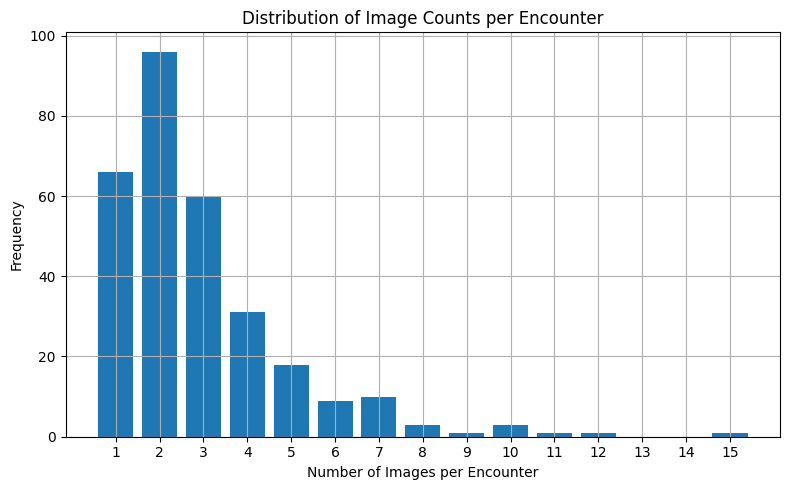

Total number of images: 877


In [ ]:
import matplotlib.pyplot as plt

df = pd.read_csv("../2025_dataset/train/final_df.csv", converters={"image_paths": eval})

image_counts = df.groupby("encounter_id")["image_paths"].first().apply(len)

plt.figure(figsize=(8, 5))
image_counts.hist(bins=range(1, image_counts.max() + 2), align="left", rwidth=0.8)
plt.xlabel("Number of Images per Encounter")
plt.ylabel("Frequency")
plt.title("Distribution of Image Counts per Encounter")
plt.xticks(range(1, image_counts.max() + 1))
plt.tight_layout()
plt.show()

total_images = image_counts.sum()
print("Total number of images:", total_images)

In [ ]:
all_images = df["image_paths"].explode().unique()
print("Unique image paths in final_df:", len(all_images))

image_dir = "../2025_dataset/train/images_train"
actual_files = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]
print("Actual image files in folder:", len(actual_files))

Unique image paths in final_df: 877
Actual image files in folder: 2472


In [ ]:
# from train.json (i.e., final_df)
listed_image_ids = set(img for sublist in final_df["image_ids"] for img in sublist)

# print first five of the listed image ids
list(listed_image_ids)[:5]

['IMG_ENC00297_00001.jpg',
 'IMG_ENC00295_00003.jpg',
 'IMG_ENC00305_00002.jpg',
 'IMG_ENC00302_00003.jpg',
 'IMG_ENC00491_00001.jpg']

In [ ]:
# from images_train directory
images_dir = os.path.join(DATA_DIR, "images_train")
actual_image_files = set(os.listdir(images_dir))

# print first five of actual_image_files
list(actual_image_files)[:5]

['IMG_ENC00662_00005.jpg',
 'IMG_ENC00620_00001.jpg',
 'IMG_ENC00798_00003.jpg',
 'IMG_ENC00672_00005.jpg',
 'IMG_ENC00548_00001.jpg']

In [ ]:
# identify images present in folder but not listed in train.json
unused_images = sorted(actual_image_files - listed_image_ids)

# preview some of the unused filenames
unused_images[:10]

['IMG_ENC00044_00001.jpg',
 'IMG_ENC00044_00002.jpg',
 'IMG_ENC00084_00001.jpg',
 'IMG_ENC00084_00002.jpg',
 'IMG_ENC00084_00003.jpg',
 'IMG_ENC00084_00004.jpg',
 'IMG_ENC00085_00001.jpg',
 'IMG_ENC00085_00002.jpg',
 'IMG_ENC00085_00003.jpg',
 'IMG_ENC00086_00001.jpg']

In [52]:
# do i have encounter_id ENC000858 in final_df?
final_df[final_df["encounter_id"] == "ENC00044"]

,encounter_id,qid,answer_index,question_en,options_en,answer_text,author_id,image_ids,responses,query_title_en,query_content_en,image_paths,responses_en


In [54]:
final_df.groupby("qid")["question_en"].nunique()

qid
CQID010-001    1
CQID011-001    1
CQID011-002    1
CQID011-003    1
CQID011-004    1
CQID011-005    1
CQID011-006    1
CQID012-001    1
CQID012-002    1
CQID012-003    1
CQID012-004    1
CQID012-005    1
CQID012-006    1
CQID015-001    1
CQID020-001    1
CQID020-002    1
CQID020-003    1
CQID020-004    1
CQID020-005    1
CQID020-006    1
CQID020-007    1
CQID020-008    1
CQID020-009    1
CQID025-001    1
CQID034-001    1
CQID035-001    1
CQID036-001    1
Name: question_en, dtype: int64

In [55]:
final_df[final_df["encounter_id"] == "ENC00001"]

,encounter_id,qid,answer_index,question_en,options_en,answer_text,author_id,image_ids,responses,query_title_en,query_content_en,image_paths,responses_en
0,ENC00001,CQID010-001,1,How much of the body is affected?,"[single spot, limited area, widespread, Not me...",limited area,U04473,"[IMG_ENC00001_00001.jpg, IMG_ENC00001_00002.jpg]","[{'author_id': 'U00217', 'content_zh': '银屑病，似与...",Pleural effusion accompanied by rash,A patient with pleural effusion is accompanied...,[c:\users\karishma\onedrive\projects\mediqa-ma...,[Psoriasis seems to have no relation to pleura...
300,ENC00001,CQID011-001,5,1 Where is the affected area?,"[head, neck, upper extremities, lower extremit...",back,U04473,"[IMG_ENC00001_00001.jpg, IMG_ENC00001_00002.jpg]","[{'author_id': 'U00217', 'content_zh': '银屑病，似与...",Pleural effusion accompanied by rash,A patient with pleural effusion is accompanied...,[c:\users\karishma\onedrive\projects\mediqa-ma...,[Psoriasis seems to have no relation to pleura...
600,ENC00001,CQID011-002,7,2 Where is the affected area?,"[head, neck, upper extremities, lower extremit...",Not mentioned,U04473,"[IMG_ENC00001_00001.jpg, IMG_ENC00001_00002.jpg]","[{'author_id': 'U00217', 'content_zh': '银屑病，似与...",Pleural effusion accompanied by rash,A patient with pleural effusion is accompanied...,[c:\users\karishma\onedrive\projects\mediqa-ma...,[Psoriasis seems to have no relation to pleura...
900,ENC00001,CQID011-003,7,3 Where is the affected area?,"[head, neck, upper extremities, lower extremit...",Not mentioned,U04473,"[IMG_ENC00001_00001.jpg, IMG_ENC00001_00002.jpg]","[{'author_id': 'U00217', 'content_zh': '银屑病，似与...",Pleural effusion accompanied by rash,A patient with pleural effusion is accompanied...,[c:\users\karishma\onedrive\projects\mediqa-ma...,[Psoriasis seems to have no relation to pleura...
1200,ENC00001,CQID011-004,7,4 Where is the affected area?,"[head, neck, upper extremities, lower extremit...",Not mentioned,U04473,"[IMG_ENC00001_00001.jpg, IMG_ENC00001_00002.jpg]","[{'author_id': 'U00217', 'content_zh': '银屑病，似与...",Pleural effusion accompanied by rash,A patient with pleural effusion is accompanied...,[c:\users\karishma\onedrive\projects\mediqa-ma...,[Psoriasis seems to have no relation to pleura...
1500,ENC00001,CQID011-005,7,5 Where is the affected area?,"[head, neck, upper extremities, lower extremit...",Not mentioned,U04473,"[IMG_ENC00001_00001.jpg, IMG_ENC00001_00002.jpg]","[{'author_id': 'U00217', 'content_zh': '银屑病，似与...",Pleural effusion accompanied by rash,A patient with pleural effusion is accompanied...,[c:\users\karishma\onedrive\projects\mediqa-ma...,[Psoriasis seems to have no relation to pleura...
1800,ENC00001,CQID011-006,7,6 Where is the affected area?,"[head, neck, upper extremities, lower extremit...",Not mentioned,U04473,"[IMG_ENC00001_00001.jpg, IMG_ENC00001_00002.jpg]","[{'author_id': 'U00217', 'content_zh': '银屑病，似与...",Pleural effusion accompanied by rash,A patient with pleural effusion is accompanied...,[c:\users\karishma\onedrive\projects\mediqa-ma...,[Psoriasis seems to have no relation to pleura...
2100,ENC00001,CQID012-001,1,1 How large are the affected areas? Please spe...,"[size of thumb nail, size of palm, larger area...",size of palm,U04473,"[IMG_ENC00001_00001.jpg, IMG_ENC00001_00002.jpg]","[{'author_id': 'U00217', 'content_zh': '银屑病，似与...",Pleural effusion accompanied by rash,A patient with pleural effusion is accompanied...,[c:\users\karishma\onedrive\projects\mediqa-ma...,[Psoriasis seems to have no relation to pleura...
2400,ENC00001,CQID012-002,3,2 How large are the affected areas? Please spe...,"[size of thumb nail, size of palm, larger area...",Not mentioned,U04473,"[IMG_ENC00001_00001.jpg, IMG_ENC00001_00002.jpg]","[{'author_id': 'U00217', 'content_zh': '银屑病，似与...",Pleural effusion accompanied by rash,A patient with pleural effusion is accompanied...,[c:\users\karishma\onedrive\projects\mediqa-ma...,[Psoriasis seems to have no relation to pleura...
2700,ENC00001,CQID012-003,3,3 H

In [ ]:
import json
from collections import Counter

cvqa_path = os.path.join("..", "2025_dataset", "train", "train_cvqa.json")

with open(cvqa_path, "r", encoding="utf-8") as f:
    data = json.load(f)

qid_sets = [set(d.keys()) - {"encounter_id"} for d in data]

question_counts = [len(qids) for qids in qid_sets]
qid_set_counter = Counter(frozenset(q) for q in qid_sets)

print("Unique question count per encounter (summary):")
print(f"Min: {min(question_counts)} | Max: {max(question_counts)} | Avg: {sum(question_counts)/len(question_counts):.2f}")
print(f"\nNumber of unique question sets: {len(qid_set_counter)}")

for i, (qs, count) in enumerate(qid_set_counter.items()):
    print(f"\nSet {i+1}: {len(qs)} questions used in {count} encounter(s)")
    print(sorted(qs))

Unique question count per encounter (summary):
Min: 27 | Max: 27 | Avg: 27.00

Number of unique question sets: 1

Set 1: 27 questions used in 300 encounter(s)
['CQID010-001', 'CQID011-001', 'CQID011-002', 'CQID011-003', 'CQID011-004', 'CQID011-005', 'CQID011-006', 'CQID012-001', 'CQID012-002', 'CQID012-003', 'CQID012-004', 'CQID012-005', 'CQID012-006', 'CQID015-001', 'CQID020-001', 'CQID020-002', 'CQID020-003', 'CQID020-004', 'CQID020-005', 'CQID020-006', 'CQID020-007', 'CQID020-008', 'CQID020-009', 'CQID025-001', 'CQID034-001', 'CQID035-001', 'CQID036-001']
